In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchmetrics.functional import accuracy
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchmetrics.functional import accuracy
from monai.networks.nets import UNet
from monai.losses import DiceLoss ,DiceCELoss
from monai.metrics import DiceMetric
import os
from tqdm.auto import tqdm
import tifffile

import logging 


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_gpus = torch.cuda.device_count()
device

'cuda'

In [3]:
class segmentation_dataset(Dataset):
    def __init__(self, image_dir, label_dir , transforms= None):
        self.image_dir = image_dir
        self.mask_dir  = label_dir
        self.transform = transforms
        
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.mask_filenames = sorted(os.listdir(self.mask_dir))
        
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img = tifffile.imread(os.path.join(self.image_dir + self.image_filenames[idx]))

        label = tifffile.imread(os.path.join(self.mask_dir + self.mask_filenames[idx]))
        
        if self.transform is not None:
            image,label = self.transform(img),self.transform(label)


        return image,label

In [4]:
data_transform = transforms.Compose([ transforms.ToTensor(),transforms.Resize((256,256))])

In [5]:
image_path = "/scratch/akaniyar/colonoscopy/CVC-ClinicDB/Original/"
mask_path = "/scratch/akaniyar/colonoscopy/CVC-ClinicDB/Ground_Truth/"

In [7]:
from sklearn.model_selection import train_test_split
dataset = segmentation_dataset(image_dir = image_path, label_dir = mask_path, transforms= data_transform)

# Split into train, validation, and test sets
train_images, val_images, train_masks, val_masks = train_test_split(dataset.image_filenames, dataset.mask_filenames, test_size=0.2)
val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.5)

# Define the datasets for each set
train_dataset = segmentation_dataset(image_dir = image_path, label_dir = mask_path, transforms= data_transform)
train_dataset.image_filenames = train_images
train_dataset.mask_filenames = train_masks

val_dataset = segmentation_dataset(image_dir = image_path, label_dir = mask_path, transforms= data_transform)
val_dataset.image_filenames = val_images
val_dataset.mask_filenames = val_masks

test_dataset = segmentation_dataset(image_dir = image_path, label_dir = mask_path, transforms= data_transform)
test_dataset.image_filenames = test_images
test_dataset.mask_filenames = test_masks

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, num_workers =num_gpus, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers =num_gpus,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64,num_workers =num_gpus, shuffle=True)

In [9]:
len(train_dataset),len(val_dataset),len(test_dataset)

(2029, 254, 254)

tensor([0.]) torch.Size([3, 256, 256])


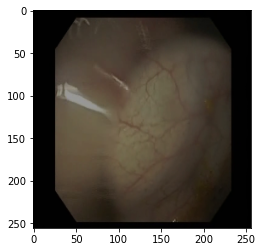

In [10]:
i,l = val_dataset[200]
print(torch.unique(l), i.shape)
plt.imshow(i.permute(1,2,0),cmap = "gray")
plt.imshow(l.permute(1,2,0),cmap = "gray" ,alpha=0.4)

In [11]:
from model import UNet
from torch.nn.parallel import DataParallel


In [12]:
model = UNet(n_channels=3,n_classes=1)
# model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
#     in_channels=3, out_channels=1, init_features=32, pretrained=True)
model = DataParallel(model, device_ids=list(range(num_gpus)), dim=0)
model =model.to(device)
model

DataParallel(
  (module): UNet(
    (inc): inconv(
      (conv): double_conv(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
    )
    (down1): down(
      (mpconv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): double_conv(
          (conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_s

In [13]:
#loss_fn = DiceLoss(softmax=False, sigmoid =True)
#loss_fn = DiceCELoss(include_background = True,sigmoid = True )
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
loss_fn

BCEWithLogitsLoss()

In [14]:
def dice_coefficient(pred, target):
    intersection = torch.sum(pred * target)
    dice = (2. * intersection) / (torch.sum(pred) + torch.sum(target))
    return dice

In [15]:
logging.basicConfig(filename='train_scratch.log', level=logging.INFO,format='%(message)s')


def train(epochs,model,dataloader):
    
    train_loss = []
    val_loss = []
    avg_test_loss = []
    avg_dc = []
    avg_dc_val = []

    for epoch in tqdm(range(epochs)):
        model.train()
        for i, data in enumerate(train_loader):
            image, label = data
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            # calculate dice coefficient and dice loss
            pred = (output > 0.5).float()
            dice = dice_coefficient(pred, label)
            dice_loss = 1 - dice

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            avg_dc.append(dice.item())
            avg_test_loss.append(dice_loss.item())

        # evaluate on validation set
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                image, label = data
                image, label = image.to(device), label.to(device)
                output = model(image)
                loss = loss_fn(output, label)

                # calculate dice coefficient and dice loss
                pred = (output > 0.5).float()
                dice = dice_coefficient(pred, label)
                dice_loss = 1 - dice

                val_loss.append(loss.item())
                avg_dc_val.append(dice.item())

        # print average losses and dice coefficients for the epoch
        train_loss_epoch = sum(train_loss) / len(train_loss)
        val_loss_epoch = sum(val_loss) / len(val_loss)
        avg_test_loss_epoch = sum(avg_test_loss) / len(avg_test_loss)
        avg_dc_epoch = sum(avg_dc) / len(avg_dc)
        avg_dc_val_epoch = sum(avg_dc_val) / len(avg_dc_val)
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss_epoch:.5f} | Val Loss: {val_loss_epoch:.5f} | Dice Loss: {avg_test_loss_epoch:.5f} | Dice Coefficient: {avg_dc_epoch:.5f} | Val Dice Coefficient: {avg_dc_val_epoch:.5f}")
    torch.save(model, f'/home/akaniyar/Colonoscopy/all_model/CVCPretrain_120.pth')
    return train_loss , val_loss
if __name__ == '__main__':
    epochs = 120
    train_loss , val_loss= train(epochs, model, train_loader)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.51193 | Val Loss: 0.47020 | Dice Loss: 0.99467 | Dice Coefficient: 0.00533 | Val Dice Coefficient: 0.00000
Epoch 2 | Train Loss: 0.44688 | Val Loss: 0.41879 | Dice Loss: 0.99690 | Dice Coefficient: 0.00310 | Val Dice Coefficient: 0.00000
Epoch 3 | Train Loss: 0.41057 | Val Loss: 0.39753 | Dice Loss: 0.99793 | Dice Coefficient: 0.00207 | Val Dice Coefficient: 0.00000
Epoch 4 | Train Loss: 0.38715 | Val Loss: 0.37706 | Dice Loss: 0.99845 | Dice Coefficient: 0.00155 | Val Dice Coefficient: 0.00000
Epoch 5 | Train Loss: 0.36878 | Val Loss: 0.36202 | Dice Loss: 0.99876 | Dice Coefficient: 0.00124 | Val Dice Coefficient: 0.00000
Epoch 6 | Train Loss: 0.35390 | Val Loss: 0.34885 | Dice Loss: 0.99897 | Dice Coefficient: 0.00103 | Val Dice Coefficient: 0.00003
Epoch 7 | Train Loss: 0.34126 | Val Loss: 0.33724 | Dice Loss: 0.99911 | Dice Coefficient: 0.00089 | Val Dice Coefficient: 0.00232
Epoch 8 | Train Loss: 0.32999 | Val Loss: 0.32606 | Dice Loss: 0.99877 | Dice Coeff

In [16]:
def test():
    test_loss = 0
    test_dice_coefficient = 0
    test_dice_loss = 0
    test_loss_avg = []
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            image, label = data
            image, label = image.to(device), label.to(device)
            output = model(image)
            loss = loss_fn(output, label)

            # calculate dice coefficient and dice loss
            pred = (output > 0.5).float()
            dice = dice_coefficient(pred, label)
            dice_loss = 1 - dice

            test_loss += loss.item()
            test_dice_coefficient += dice.item()
            test_dice_loss += dice_loss.item()
            test_loss_avg.append(test_loss)
        # calculate average test loss, dice coefficient, and dice loss
        test_loss /= len(test_loader)
        test_dice_coefficient /= len(test_loader)
        test_dice_loss /= len(test_loader)

        print(f"Test Loss: {test_loss:.5f} | Dice Loss: {test_dice_loss:.5f} | Dice Coefficient: {test_dice_coefficient:.5f}")


        return test_loss_avg
    
x=test()

Test Loss: 0.01900 | Dice Loss: 0.07866 | Dice Coefficient: 0.92134


In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("UNet(pretrain) on Jsrt Dataset")
#plt.savefig("/Users/aniru/Desktop/Image_analytics_and_informatics/Train_test_val_plot_pretrain.png",dpi=300)
plt.show()


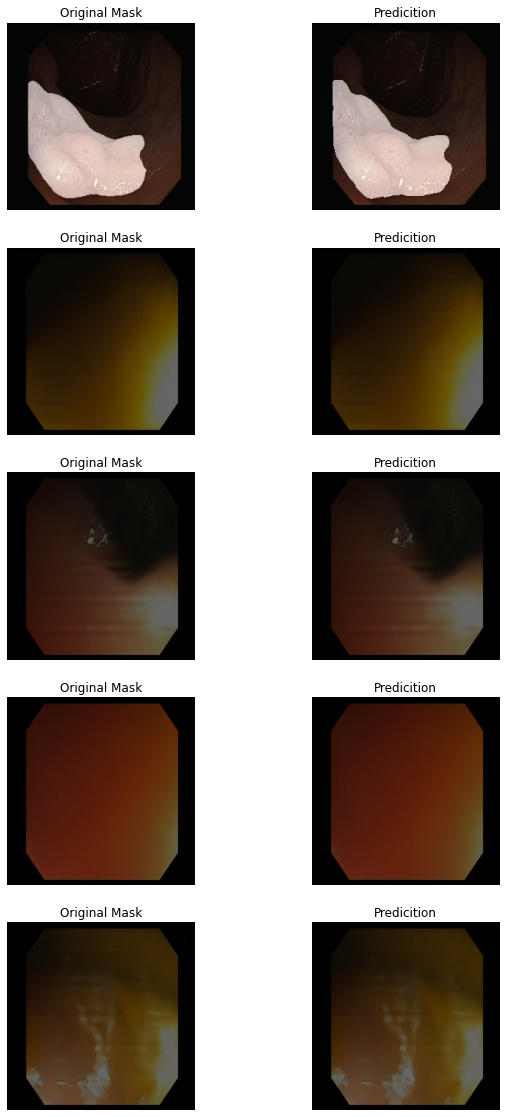

In [18]:
n_max_imgs = 5

plt.figure(figsize=(10, 20))
for n in range(n_max_imgs):
    model.eval()
    x, t = test_dataset[n]
    x,t = x.to(device) , t.to(device)
    y = model(x.unsqueeze(0)) 
    y_label = (y>0.5).int().squeeze()
    
    #t = np.squeeze(t) 
    #print(torch.unique(y_label))
    t = t.cpu()
    
    z = y_label.cpu()
    
    plt.subplot(n_max_imgs, 2, 2*n+1)
    plt.imshow(x.cpu().permute(1,2,0),cmap = "gray")
    plt.imshow(t.permute(1,2,0),cmap = "gray",alpha = 0.6)
    plt.title("Original Mask")
    plt.axis(False);
    plt.subplot(n_max_imgs, 2, 2*n+2)
    plt.imshow(x.cpu().permute(1,2,0),cmap = "gray")
    plt.imshow(z,cmap = "gray",alpha = 0.6)
    plt.title("Predicition")
    plt.axis(False);
    plt.savefig("scratch120CVC-ClinicDB.png",dpi=330)